In [11]:
import numpy as np
import mrcfile
from matplotlib import pyplot as plt
%matplotlib inline
import collections
import tensorflow as tf
from tensorflow import spectral

In [ ]:
from relion_fixed_it import load_star

In [ ]:
sess = tf.InteractiveSession()
base_path = '/local/scratch/public/sl767/SPA/playing2/'
path=base_path+'Refine3D/1Q9J/1Q9J_mult005_it013_class001_external_reconstruct.star'

In [ ]:
file=load_star(path)

In [ ]:
type(file)

In [ ]:
for key, data in file.items():
    print(key)

In [ ]:
for key, data in file['external_reconstruct_general'].items():
    print(key)
    print(data)

In [ ]:
with mrcfile.open(base_path+file['external_reconstruct_general']['rlnExtReconsDataReal']) as mrc:
    data_real = mrc.data
with mrcfile.open(base_path+file['external_reconstruct_general']['rlnExtReconsDataImag']) as mrc:
    data_im = mrc.data
with mrcfile.open(base_path+file['external_reconstruct_general']['rlnExtReconsWeight']) as mrc:
    kernel = mrc.data

In [ ]:
complex_data = data_real + 1j * data_im

In [ ]:
complex_data.shape

In [ ]:
data = tf.placeholder(shape=(96, 96, 49), dtype=tf.complex64)
ft = spectral.irfft3d(data)

In [ ]:
image = sess.run(ft, feed_dict={data: complex_data})

In [ ]:
image.shape

In [ ]:
plt.imshow(image[...,40])

In [ ]:
plt.imshow(data_real[...,20])

In [ ]:
new_conv = np.fft.fftshift(complex_data, axes=(0, 1))
plt.imshow(np.real(new_conv[...,0]))
plt.clim(-1e7,1e7)

In [ ]:
image = sess.run(ft, feed_dict={data: new_conv})

In [ ]:
plt.imshow(image[...,0])

In [ ]:
image.shape

In [ ]:
new_conv.max()

In [ ]:
with mrcfile.open('/local/scratch/public/sl767/SPA/playing2/1Q9J.mrc') as mrc:
    molecule = mrc.data

In [ ]:
real_inp = tf.placeholder(shape=(96,96,96), dtype=tf.float32)
fourierData = spectral.rfft3d(real_inp)

In [ ]:
plt.imshow(molecule[...,20])

In [ ]:
fou = sess.run(fourierData, feed_dict={real_inp: molecule})

In [ ]:
plt.imshow(np.real(fou[...,20]))

In [ ]:
fou.shape

In [ ]:
plt.imshow(sess.run(ft, feed_dict={data:fou})[...,20])

In [ ]:
plt.imshow(np.real(np.fft.rfftn(molecule)[...,20]))

In [ ]:
plt.imshow(np.fft.fftshift(image)[...,50], clim=(0,600))

In [ ]:
plt.imshow(molecule[...,50], clim=(0,12))

In [ ]:
molecule.max()

In [ ]:
molecule.min()

In [ ]:
np.fft.fftshift(image).max()

In [ ]:
np.fft.fftshift(image).min()

In [ ]:
import odl
from odl.contrib import tensorflow
import numpy as np
import tensorflow as tf

In [ ]:
space = odl.uniform_discr([0, 0, 0], [96, 96 ,96], [96, 96, 96],
                                             dtype='float32')

In [ ]:
class ifftshift_odl(odl.Operator):
    def _call(self, x):
        return space.element(np.fft.ifftshift(x))
    
    def __init__(self):
        super(ifftshift_odl, self).__init__(space, space, linear=True)

class fftshift_odl(odl.Operator):
    def _call(self, x):
        return space.element(np.fft.fftshift(x))
    
    def __init__(self):
        super(fftshift_odl, self).__init__(space, space, linear=True)
        
    @property
    def adjoint(self):
        return ifftshift_odl()
fftshift_tf = odl.contrib.tensorflow.as_tensorflow_layer(fftshift_odl())

In [ ]:
x = np.ones(shape=(96,96,96))
y = fftshift_odl().adjoint(x)

In [ ]:
(ifftshift_odl()(fftshift_odl()(molecule))-molecule).__array__().max()

In [ ]:
fft_tf = odl.contrib.tensorflow.as_tensorflow_layer(fftshift_odl())

In [ ]:
FOURIER_SIZE = (None, 96, 96, 49,1)
t = tf.placeholder(shape=FOURIER_SIZE, dtype=tf.complex64)
y = tf.expand_dims(tf.spectral.irfft3d(t[...,0]), axis=-1)

In [ ]:
sess = tf.InteractiveSession()

In [ ]:
res = sess.run(y, feed_dict={t:np.ones(shape=(5,96,96,96,1))})

In [ ]:
y.shape

In [ ]:
y_sh = fftshift_tf(y)

In [ ]:
y_sh.shape

In [ ]:
conv1 = tf.layers.conv3d(inputs=y, filters=16, kernel_size=[3, 3, 3], padding="same",
                                 activation=tf.nn.relu, reuse=tf.AUTO_REUSE, name='conv1')

In [ ]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

In [ ]:
import numpy as np
import mrcfile 
with mrcfile.open('/local/scratch/public/sl767/SPA/playing2/1Q9J.mrc') as mrc:
    molecule = mrc.data

In [ ]:
x = np.random.uniform(0,1,(96,96,96))
y = np.fft.rfftn(x)

In [ ]:
ft.shape

In [ ]:
mask = np.concatenate((np.ones(shape=(96,96,1)), 2*np.ones(shape=(96,96,47)),np.ones(shape=(96,96,1))), axis=-1)
mask2 = np.concatenate((np.ones(shape=(96,96,1)), 2*np.ones(shape=(96,96,94)),np.ones(shape=(96,96,1))), axis=-1)

In [ ]:
def scal(a,b):
    return np.dot(np.reshape(a, -1), np.conj(np.reshape(b, -1)))

In [ ]:
scal(y,np.multiply(y, mask))/(96*96*96)

In [ ]:
scal(x,x)

In [ ]:
scal(y,np.fft.rfftn(np.multiply(x, mask2)))/(96*96*96)

In [ ]:
import numpy as np
import mrcfile 
with mrcfile.open('/local/scratch/public/sl767/SPA/playing2/1Q9J.mrc') as mrc:
    molecule = mrc.data
molecules = np.ones(shape=(2,96,96,96,1))
molecules[0,...,0]=molecule
from ClassFiles.ut import normalize
from ClassFiles.ut import l2

In [ ]:
import tensorflow as tf
sess = tf.InteractiveSession()

In [ ]:
REAL_SIZE = (None, 96, 96, 96,1)
t = tf.placeholder(shape=REAL_SIZE, dtype=tf.float32)

In [ ]:
norms = tf.sqrt(tf.reduce_sum(tf.square(t), axis=(1,2,3)))
norms_exp = tf.expand_dims(tf.expand_dims(tf.expand_dims(norms, axis=1), axis=1), axis=1)

In [ ]:
norms.shape

In [ ]:
norms_exp.shape

In [ ]:
result = tf.div(t, norms_exp)

In [ ]:
normed = sess.run(result, feed_dict={t: molecules})

In [ ]:
comp = normalize(molecules)

In [ ]:
l2(normed-comp)/l2(comp)

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
REAL_SIZE = (None, 96, 96, 96,1)
t = tf.placeholder(shape=REAL_SIZE, dtype=tf.float32)

In [ ]:
y = tf.spectral.rfft3d(t)
phase = 2*np.pi*tf.random_uniform(shape=tf.shape(y), minval= 0, maxval=1)
com_phase = tf.exp(1j*tf.cast(phase, tf.complex64))
y = tf.multiply(com_phase, y)

In [8]:
from ClassFiles import tensorflow_rotations
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline
from ClassFiles.ut import find
import random

In [9]:
import numpy as np
import scipy.linalg
import mrcfile 
with mrcfile.open('/local/scratch/public/sl767/SPA/playing2/1Q9J.mrc') as mrc:
    molecule = mrc.data
molecules = np.ones(shape=(1,96,96,96,1))
molecules[0,...,0]=molecule
from ClassFiles.ut import l2
# sess = tf.InteractiveSession()

In [5]:
l2(molecule)

336.56775

In [6]:
PATH = '/local/scratch/public/sl767/MRC_Data/org/'
PATH_ADV = '/local/scratch/public/sl767/MRC_Data/Data_002_10k/EM/'

train_list = find('*it013_half2_class001_external_reconstruct.mrc', PATH_ADV)
train_amount = len(train_list)
print('Training Pictures found: ' + str(train_amount))
eval_list = ''
eval_amount = len(eval_list)
print('Evaluation Pictures found: ' + str(eval_amount))


def locate_gt(adversarial_path):
    pdb_id = adversarial_path[-63:-59]
    l = find('*'+pdb_id+'.mrc', PATH)
    if not len(l)==1:
        raise ValueError('non-unique pdb id: '+l)
    else:
        return l[0]


def get_image(number, training):
    if training:
        L = train_list
    else:
        L = eval_list
    adv_path=L[number]
    print(adv_path)
    with mrcfile.open(adv_path) as mrc:
        adv = mrc.data
    with mrcfile.open(locate_gt(adv_path)) as mrc:
        gt = mrc.data
    return gt, adv


def load_data(training_data=True):
    if training_data:
        n = train_amount
    else:
        n = eval_amount
    return get_image(random.randint(0, n-1), training=training_data)

Training Pictures found: 47
Evaluation Pictures found: 0


In [7]:
gt, sgd = load_data()
gt = np.expand_dims(np.expand_dims(gt, 0), -1)/l2(gt)
sgd = np.expand_dims(np.expand_dims(sgd, 0), -1)/l2(sgd)

/local/scratch/public/sl767/MRC_Data/Data_002_10k/EM/3Q0R/3Q0R_mult002_it013_half2_class001_external_reconstruct.mrc


In [ ]:
train_list[0][-63:-59]

In [ ]:
l2(gt)

In [ ]:
rotation_matrix = np.zeros(shape=(3,3))
rotation_matrix[0,0] = 1
rotation_matrix[1,2] = -1
rotation_matrix[2,1] = 1

rotation_matrix = np.eye(3, 3)
rotation_matrix[0,0] = -1
rotation_matrix[1,1] = -1

In [ ]:
exponent = 0.2 * np.random.randn(3, 3)
rotation_matrix = scipy.linalg.expm((exponent - exponent.T) / 2)

In [ ]:
rotation_matrix

In [ ]:
translation=0.05*np.random.randn(3,1)
translation

In [ ]:
theta = np.concatenate((rotation_matrix, translation), axis=1)

In [ ]:
theta = np.expand_dims(theta, 0)

In [ ]:
inp = tf.placeholder(shape=(None, 96,96,96,1), dtype=tf.float32)
rotated = tensorflow_rotations.rot3d(inp, theta.astype('float32'))

In [ ]:
rot_im = sess.run(rotated, feed_dict={inp: molecules})

In [ ]:
rot_im.shape

In [ ]:
molecules.shape

0.859401


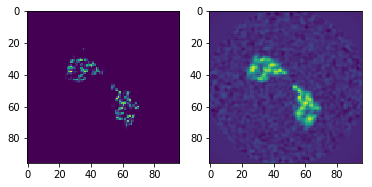

In [8]:
plt.figure()
plt.subplot(121)
plt.imshow(gt[0,...,45,0])
plt.subplot(122)
plt.imshow(sgd[0,...,45,0])
print(l2(sgd-gt))

In [ ]:
print(theta[0,...])

In [ ]:
# The tensorflow rotation methods

In [ ]:
image_feed = tf.placeholder(shape=(None, 96,96,96 ,1), dtype=tf.float32)
reference_feed = tf.placeholder(shape=(None, 96,96,96 ,1), dtype=tf.float32)
noise = tf.placeholder(shape=(), dtype=tf.float32)

if 1:
    k = 1
    image = tf.layers.average_pooling3d(image_feed, k, k)
    reference = tf.layers.average_pooling3d(reference_feed, k, k)

In [ ]:
basis_exp = tf.Variable(tf.zeros(shape=(3,3)))
skew_exp = basis_exp - tf.transpose(basis_exp)
rotation = tf.linalg.expm(skew_exp)
translation = tf.Variable(tf.zeros(shape=(3,1)))
theta = tf.concat([rotation, translation], axis=-1)

In [ ]:
rot_image = tensorflow_rotations.rot3d(image, theta)

In [ ]:
diff = rot_image - reference

data_fit = tf.reduce_sum(tf.square(diff))
for i in range(1, 4):
    data_fit += tf.reduce_sum(tf.square(tf.layers.average_pooling3d(diff, 2 ** i, 2 ** i)))

# outside_reg = tf.reduce_mean(tf.square(reference)) - tf.reduce_mean(tf.square(rot_image))
regularizer = 0.01 * tf.reduce_sum(tf.square(reference)) * tf.reduce_sum(tf.square(translation))

loss = data_fit + regularizer

In [ ]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(loss)

with tf.control_dependencies([optimizer]):
    assign = tf.group(tf.assign_add(basis_exp, np.pi * noise * tf.random_normal(shape=(3, 3))),
                      tf.assign_add(translation, noise * tf.random_normal(shape=(3, 1))))

In [ ]:
tf.global_variables_initializer().run()

IMAX = 60
for i in range(IMAX):
    _, _, ld, lr, matrix, trans = sess.run([optimizer, assign, data_fit, regularizer, rotation, translation], 
                            feed_dict={image_feed: sgd, 
                                       reference_feed: gt,
                                       noise: 0.001 * (i < IMAX // 2)})
    if i%3==0:
        print(ld, lr)
        print(matrix)

In [ ]:
im1, im2 = sess.run([reference,rot_image], feed_dict={image_feed:sgd, reference_feed: gt})

In [ ]:
plt.figure(figsize=(15,3.5))
plt.subplot(131)
plt.imshow(gt.squeeze().mean(axis=1))
plt.colorbar()
plt.subplot(132)
plt.imshow(sgd.squeeze().mean(axis=1))
plt.colorbar()
plt.subplot(133)
plt.imshow(reg_im.squeeze().mean(axis=1))
plt.colorbar()

In [1]:
from ClassFiles.registration import LocalRegistrator

In [2]:
reg = LocalRegistrator()

In [9]:
reg_im=reg.register(gt, sgd)

0.777433
0.684317
0.515994
0.465079
0.453072
Final Registration Loss: 0.442759
Rotation: 
[[  9.99972880e-01  -7.29993870e-03   1.00849557e-03]
 [  7.30384141e-03   9.99965608e-01  -3.92225152e-03]
 [ -9.79828881e-04   3.92951071e-03   9.99991715e-01]]
Translation: 
[[-0.00777616]
 [-0.00854683]
 [-0.00723018]]


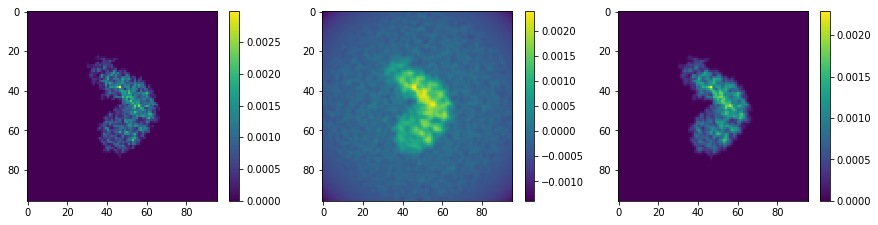

In [10]:
plt.figure(figsize=(15,3.5))
plt.subplot(131)
plt.imshow(gt.squeeze().mean(axis=1))
plt.colorbar()
plt.subplot(132)
plt.imshow(sgd.squeeze().mean(axis=1))
plt.colorbar()
plt.subplot(133)
plt.imshow(reg_im.squeeze().mean(axis=1))
plt.colorbar()

In [12]:
reg_im=reg.register(image=sgd, reference=gt)

0.777436
0.719502
0.709269
0.70649
0.701319
Final Registration Loss: 0.701748
Rotation: 
[[ 0.9992769   0.03616333 -0.01174391]
 [-0.03605265  0.9993047   0.00950415]
 [ 0.01207944 -0.00907388  0.99988586]]
Translation: 
[[-0.00029438]
 [-0.00020427]
 [ 0.0001248 ]]


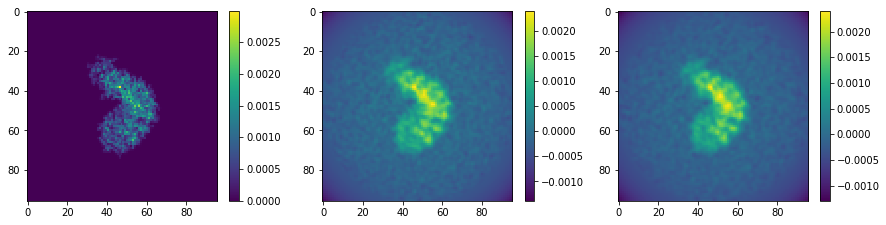

In [13]:
plt.figure(figsize=(15,3.5))
plt.subplot(131)
plt.imshow(gt.squeeze().mean(axis=1))
plt.colorbar()
plt.subplot(132)
plt.imshow(sgd.squeeze().mean(axis=1))
plt.colorbar()
plt.subplot(133)
plt.imshow(reg_im.squeeze().mean(axis=1))
plt.colorbar()

In [21]:
st = '/local/scratch/public/sl767/MRC_Data/Data_002_10k/TestAR/9ICA/9ICA_mult002_it011_half2_model.star'

In [22]:
l = st.split('_')
for det in l:
    if det[0:2]=='it':
        it = det[2:5]
print(int(it))

11


In [10]:
with mrcfile.open('/local/scratch/public/sl767/MRC_Data/Data_002_10k/ValidateExternal/Iteration_7.mrc') as mrc:
    comp = mrc.data

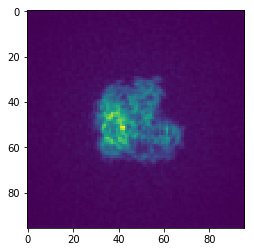

In [13]:
plt.imshow(comp.mean(axis=-1))

In [5]:
import numpy as np
import mrcfile
from matplotlib import pyplot as plt
%matplotlib inline
import collections
import tensorflow as tf
from tensorflow import spectral
from ClassFiles.ut import l2
from ClassFiles.ut import get_coordinate_change

In [3]:
rnd = np.random.normal(size=(96,96,96))
ft = np.fft.fftn(rnd)

In [6]:
l2(rnd)

940.28095094484183

In [8]:
l2(ft)/(96**(3/2))

940.28095094484183

In [58]:
def sobolev_mask(power=1.0, cutoff=100.0):    
    print(cutoff)
    print(power)
    X, Y, Z = np.meshgrid(np.linspace(-1, 1, 96),
                          np.linspace(-1, 1, 96),
                          np.linspace(-1, 1, 96))

    R = np.sqrt(X ** 2 + Y ** 2 + Z ** 2)
    R = np.fft.fftshift(R)

    R = R ** power
    R = np.maximum(R, np.max(R)/cutoff)
    R = R / np.min(R)
    return R

In [59]:
mask = sobolev_mask()
mask_i = sobolev_mask(power = -1.0)

100.0
1.0
100.0
-1.0


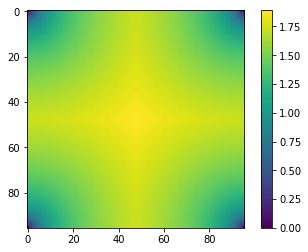

In [62]:
plt.imshow(np.log10((mask)[...,0]))
plt.colorbar()

In [101]:
tensor = tf.placeholder(shape=(None, 96,96,96,1), dtype=tf.float32)

def sobolev_norm(tensor, s=1.0):
    mask = tf.constant(sobolev_mask(), dtype=tf.complex64)
    s = tf.shape(tensor)
    scaling = tf.sqrt(tf.cast(s[1]*s[2]*s[3], dtype=tf.complex64))

    # move channels in as fourier transform is taken over the three innermost dimensions
    tensor = tf.transpose(tensor, [0, 4, 1, 2 ,3])
    fourier= tf.spectral.fft3d(tf.cast(tensor, dtype=tf.complex64))/scaling

    masked = tf.multiply(fourier, mask)
    return l2_tf(masked)

In [102]:
error = sobolev_norm(tensor)

100.0
1.0


In [100]:
def l2_tf(tensor):
    return tf.sqrt(tf.reduce_sum(tf.square(tf.abs(tensor)), axis = (1,2,3,4)))

In [103]:
error

<tf.Tensor 'Sqrt_15:0' shape=(?,) dtype=float32>